# 一次元CNNの時系列解析

In [83]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### とりあえずダミーデータ作成

(100,)
(10000, 100)


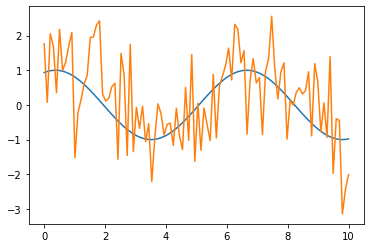

In [84]:
n_sample = 10000
data_length = 100

x = np.linspace(0,10,data_length)          #基準の時間軸生成
_x = np.random.randn(n_sample,1)           #sin波を生成するために作成
y = np.sin(x.reshape(1,data_length)+_x)    #sin波を適当にn_sample作成(n_sample,data_length)
#外乱（工学的にdを採用しただけ）→noiseとかw(white noise)のがいい？
d = [np.random.randn(data_length) for i in range(n_sample)]
y_origin = y
y_noise = y + d

print(x.shape)      #(data_length,)→(100,)
print(y.shape)      #(n_sample,data_length)→(10000,100)

#二つだけプロット
plt.plot(x,y_origin[0])
plt.plot(x,y_noise[1])

## 必要そうな関数作成

#### 全結合層

In [85]:
class Affine():
    pass

#### Pooling層

In [86]:
class Pooling():
    pass

#### Atrous層

#### バッチ正規化

#### im2col col2imテスト

In [87]:
a = np.arange(12).reshape(3,4)
X = np.concatenate((a,a+4)).reshape(2,3,4)    #X(B,C_in,X_in)
X

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]])

In [88]:
W = np.arange(18).reshape(2,3,3)    #W(C_out,C_in,F_w)
W

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]]])

In [89]:
Y = np.zeros((2,2,2))    #Y(B,C_out,X_out)

for i in range(2):
    for j in range(2):
        for k in range(2):
            Y[j,i,k] = np.sum(X[j,0:3,k:k+3]*W[i,0:3,0:3])
Y    #Y(B,C_out,X_out)

array([[[ 258.,  294.],
        [ 663.,  780.]],

       [[ 402.,  438.],
        [1131., 1248.]]])

In [90]:
def im2col(img,F_w,X_out):
    #入力時系列データの形を取得
    B, C_in, X_in = img.shape
    
    col = np.zeros((B,C_in,F_w,X_out))    #(B,C_in,F_w,X_out)
    
    for w in range(F_w):
        col[:,:,w,:] = X[:,:,w:w+X_out]
    
    col = col.transpose(1,2,0,3).reshape(9,4)    #(C_in,F_w,B,X_out)→(C_in*F_w,B*X_out)
    
    return col

X_col = im2col(X,3,2)
print("X =\n",X_col)
print("W =\n",W.reshape(2,9))
w_col = W.reshape(2,9)                   #(C_out,C_in*F_w)
print(np.dot(W.reshape(2,9),X_col).T)

Y = np.dot(w_col,X_col).T.reshape(2,2,2).transpose(0,2,1)
print("Y =\n",Y)


X =
 [[ 0.  1.  4.  5.]
 [ 1.  2.  5.  6.]
 [ 2.  3.  6.  7.]
 [ 4.  5.  8.  9.]
 [ 5.  6.  9. 10.]
 [ 6.  7. 10. 11.]
 [ 8.  9. 12. 13.]
 [ 9. 10. 13. 14.]
 [10. 11. 14. 15.]]
W =
 [[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]]
[[ 258.  663.]
 [ 294.  780.]
 [ 402. 1131.]
 [ 438. 1248.]]
Y =
 [[[ 258.  294.]
  [ 663.  780.]]

 [[ 402.  438.]
  [1131. 1248.]]]


#### 畳み込み層

In [91]:
class convlayer1D:
    def __init__(self,C_in,X_in,C_out,F_w=3,stride=1,pad=0,activation="ReLU"):
        self.params = {"C_in":C_in, "X_in":X_in, "C_out":C_out, "F_w":F_w, "S":stride, "P":pad}
        
        #Heの初期値前脳のノード数nの時(2/n)^1/2
        He_w = X_in * C_in
        He_b = X_in
        self.W = np.sqrt(2/He_w) * np.random.randn(C_out,C_in,F_w)
        self.b = np.sqrt(2/He_b) * np.random.randn(1,C_out)
        
        #出力画像サイズ
        self.y_ch = C_out                                             #出力データchannel
        self.y_w  = (X_in - F_w + 2*pad) // stride + 1                #出力データ幅
        
        
        self.h_w = np.zeros((C_out,C_in,F_w)) + 1e-8
        self.h_b = np.zeros((1,C_out)) + 1e-8
    
    #引数：入力データ
    def _im2col(self,img):
        #入力時系列データの形を取得
        self.B, self.C_in, self.X_in = img.shape

        col = np.zeros((self.B,self.params["C_in"],self.params["F_w"],self.y_w))    #(B,C_in,F_w,X_out)

        for w in range(self.params["F_w"]):
            col[:,:,w,:] = img[:,:,w:w+self.y_w]

        col = col.transpose(1,2,0,3).reshape(self.params["C_in"]*self.params["F_w"],self.B*self.y_w)    #(C_in,F_w,B,X_out)→(C_in*F_w,B*X_out)

        return col
    
    
    def _col2im(self,col):
        
        col = a#処理
        
        
        return img

    
    
    def forward(self,X):
        
        self.X_col = self._im2col(X)
        self.w_col = self.W.reshape(self.params["C_out"], self.params["C_in"]*self.params["F_w"])
        u = np.dot(w_col, X_col).T + self.b
        self.u = u.reshape(self.B, self.y_w, self.y_ch).transpose(0, 2, 1)
        #ReLU
        #後で活性化関数を任意に決定できるように実装する
        Y = np.maximum(0, u)
        
        return Y
    
    
    
    def backward(self,dy):
        
        delta = dy*np.maximum(0,self.u)
        delta = delta.transpose(0,2,1).reshape(self.B*self.y_w,self.params["C_out"])
        
        dw = np.dot(self.X_col,delta)
        self.dw = dw.T.reshape(self.params["C_out"],self.params["C_in"],self.params["F_w"])
        self.db = np.sum(selta,axis=0)
        
        dcol = np.dot(delta,self.w_col)
        self.dX = self._col2im(dcol.T)
        
        return self.dX
        
    def fit(self,eta):##adaGrad→変更できるように
        self.h_w += self.dw**2
        self.w -= eta/np.sqrt(self.h_w)*self.grad_w
        
        self.h_b += self.db**2
        self.b -= eta/np.sqrt(self.h_b)*self.grad_b

# クラス化

# アーキテクチャ構築

In [122]:
X = np.random.rand(4,2,6)    #X(B,C_in,X_in)

conv1 = convlayer1D(2,6,4)  #C_in,X_in,C_out,F_w=3,stride=1,pad=0
conv1.forward(X)

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.08286357, 0.        , 0.        , 0.        ],
        [0.28734516, 0.3363552 , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.06212582, 0.        , 0.        ],
        [0.98402697, 0.32046315, 0.32617135, 0.28056356],
        [0.0454527 , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.04952165],
        [0.        , 0.        , 0.        , 0.        ],
        [0.74894583, 0.18278601, 0.        , 0.17841878],
        [0.        , 0.07827255, 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.6277939 , 0.64041309, 0.72213454, 0.77845986],
        [0.        , 0.        , 0.        , 0.        ]]])

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

NameError: name 'col' is not defined